# COVID-19

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
URL = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
FMT = '%Y-%m-%d %H:%M:%S'

def days_to_datetime(days):
    return (datetime(2020, 1, 1) + timedelta(days)).strftime('%Y-%m-%d')

## Logistic model

In [3]:
def logistic_model(x, a, b, c):
    return c/(1+np.exp(-(x-b)/a))

def logistic_model_derivative(x, a, b, c):
    return (c*np.exp((b - x)/a)) / (a * pow((1 + np.exp((b - x)/a)), 2))

## Load and preprocess data

In [4]:
df = pd.read_csv(URL)
df = df.loc[:,['data', 'totale_attualmente_positivi', 'nuovi_attualmente_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi']]
date = df['data']
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days)

## Trends

In [5]:
x = np.array(df.iloc[:,0])
active_cases = np.array(df.iloc[:,1])
new_cases = np.array(df.iloc[:,2])
recovered = np.array(df.iloc[:,3])
deaths = np.array(df.iloc[:,4])
total_cases = np.array(df.iloc[:,5])
new_recovered = np.hstack([0, np.ediff1d(recovered)])
new_deaths = np.hstack([0, np.ediff1d(deaths)])
print(datetime.now().strftime("%Y-%m-%d %H:%M"))
print()
print(f'Active cases  = {active_cases[-1]}')
print(f'New cases     = {new_cases[-1]}')
print(f'Recovered     = {recovered[-1]}')
print(f'New recovered = {new_recovered[-1]}')
print(f'Deaths        = {deaths[-1]}')
print(f'New deaths    = {new_deaths[-1]}')
print(f'Total cases   = {total_cases[-1]}')

2020-03-23 18:56

Active cases  = 50418
New cases     = 3780
Recovered     = 7432
New recovered = 408
Deaths        = 6077
New deaths    = 601
Total cases   = 63927


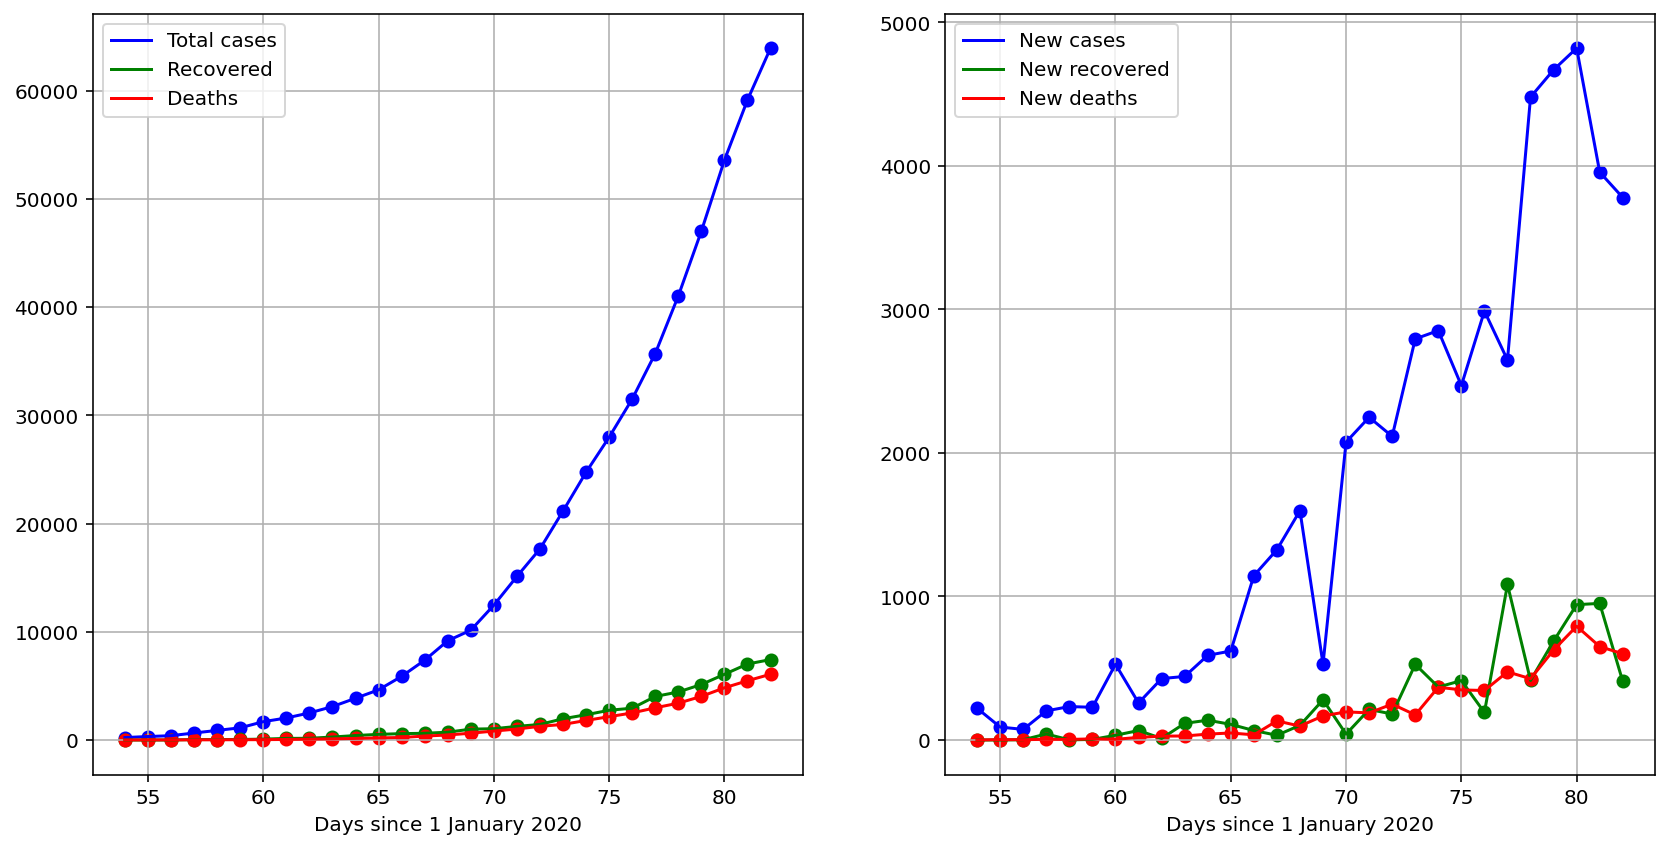

In [6]:
plt.rcParams['figure.figsize'] = [14, 7]
plt.subplot(1, 2, 1)
plt.scatter(x, total_cases, color='blue')
plt.plot(x, total_cases, 'b', label='Total cases')
plt.scatter(x, recovered, color='green')
plt.plot(x, recovered, 'g', label='Recovered')
plt.scatter(x, deaths, color='red')
plt.plot(x, deaths, 'r', label='Deaths')
plt.xlabel('Days since 1 January 2020')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(x, new_cases, color='blue')
plt.plot(x, new_cases, 'b', label='New cases')
plt.scatter(x, new_recovered, color='green')
plt.plot(x, new_recovered, 'g', label='New recovered')
plt.scatter(x, new_deaths, color='red')
plt.plot(x, new_deaths, 'r', label='New deaths')
plt.xlabel('Days since 1 January 2020')
plt.legend()
plt.grid(True)

## Fit logistic model on total cases

In [7]:
fit = curve_fit(logistic_model, x, total_cases, p0=[4, 100, 50000])
a, b, c = fit[0]
_, err_b, err_c = (np.sqrt(fit[1][i][i]) for i in [0, 1, 2])
sol = fsolve(lambda x : logistic_model(x, a, b, c) - int(c), b)[0]
print(f'Expected number of infected people = {c:.2f} ± {int(np.ceil(err_c))}')
print(f'Expected infection peak = {days_to_datetime(b)} ± {int(np.ceil(err_b))} days')
print(f'Expected infection end = {days_to_datetime(sol)}')

Expected number of infected people = 117476.81 ± 5453
Expected infection peak = 2020-03-22 ± 1 days
Expected infection end = 2020-05-22


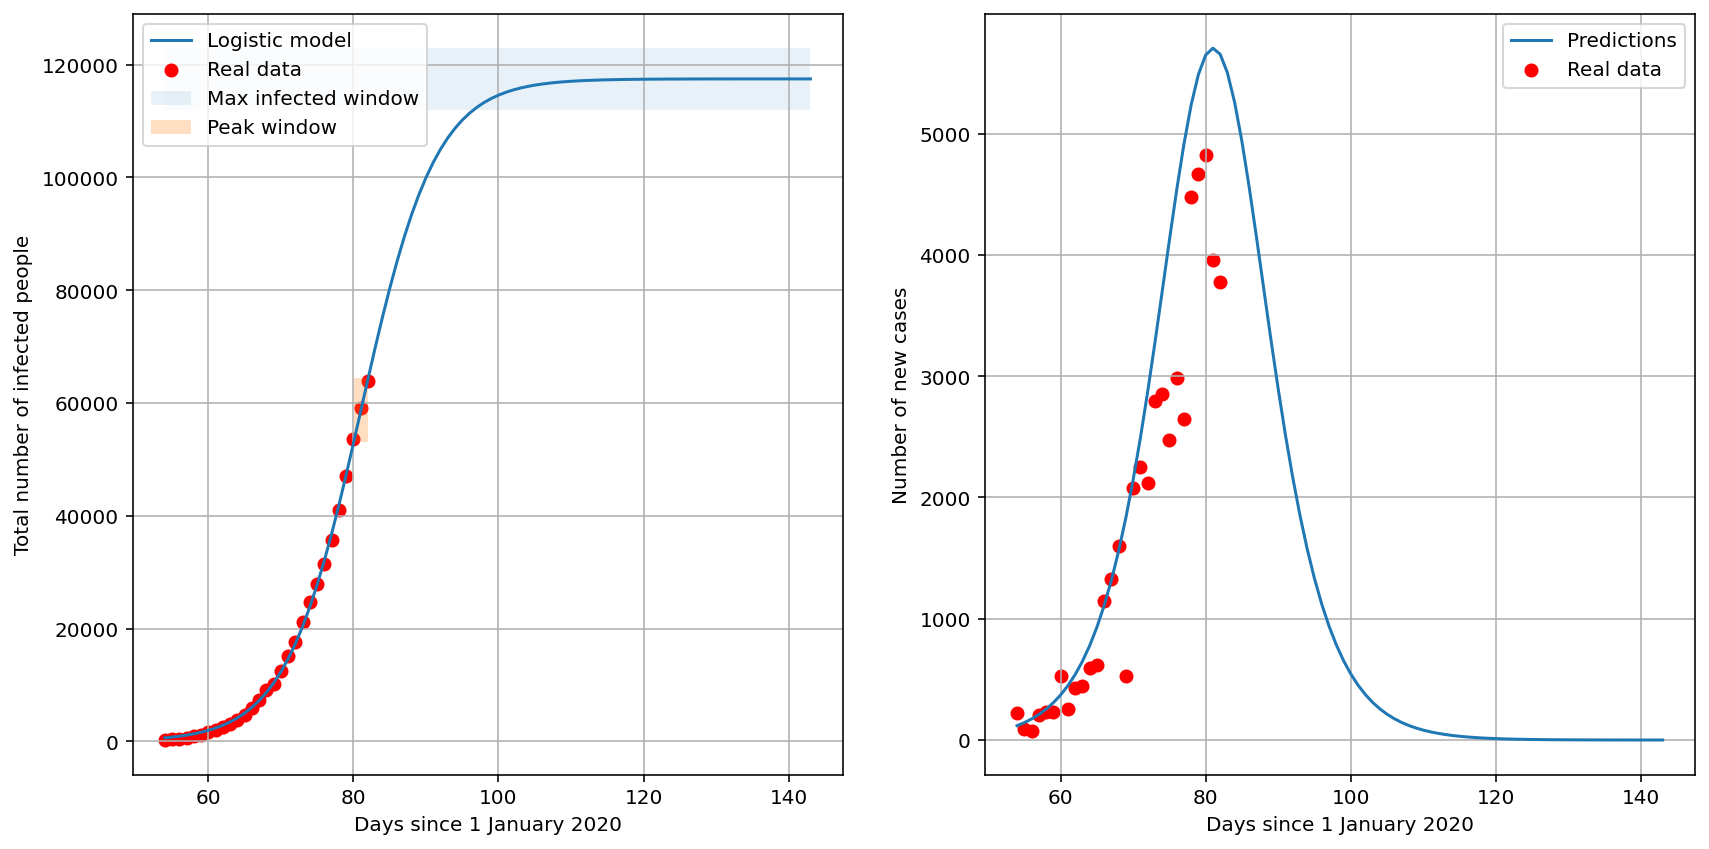

In [8]:
pred_x = np.arange(x.min(), sol+1)
pred_total_cases = logistic_model(pred_x, a, b, c)
plt.subplot(1, 2, 1)
plt.scatter(x, total_cases, label='Real data', color='red')
plt.plot(pred_x, pred_total_cases, label='Logistic model')
plt.fill_between(pred_x, c - err_c, c + err_c, alpha=0.1, label='Max infected window')
plt.fill_between([b - np.ceil(err_b), b + np.ceil(err_b)], 
                 logistic_model(b - np.ceil(err_b), a, b, c),
                 logistic_model(b + np.ceil(err_b), a, b, c),
                 alpha=0.25, label='Peak window')
plt.xlabel('Days since 1 January 2020')
plt.ylabel('Total number of infected people')
plt.legend()
plt.grid(True)

pred_new_cases = logistic_model_derivative(pred_x, a, b, c)
plt.subplot(1, 2, 2)
plt.scatter(x, new_cases, label='Real data', color='red')
plt.plot(pred_x, pred_new_cases, label='Predictions')
plt.xlabel('Days since 1 January 2020')
plt.ylabel('Number of new cases')
plt.legend()
plt.grid(True)

## Fit derivative of logistic model with new cases

In [9]:
fit = curve_fit(logistic_model_derivative, x, new_cases, p0=[4, 100, 50000])
a, b, c = fit[0]
_, err_b, err_c = (np.sqrt(fit[1][i][i]) for i in [0, 1, 2])
sol = int(fsolve(lambda x : logistic_model(x, a, b, c) - int(c), b)[0])
print(f'Expected number of infected people = {c:.2f} ± {int(np.ceil(err_c))}')
print(f'Expected infection peak = {days_to_datetime(b)} ± {int(np.ceil(err_b))} days')
print(f'Expected infection end = {days_to_datetime(sol)}')

Expected number of infected people = 92148.05 ± 13692
Expected infection peak = 2020-03-22 ± 2 days
Expected infection end = 2020-06-08


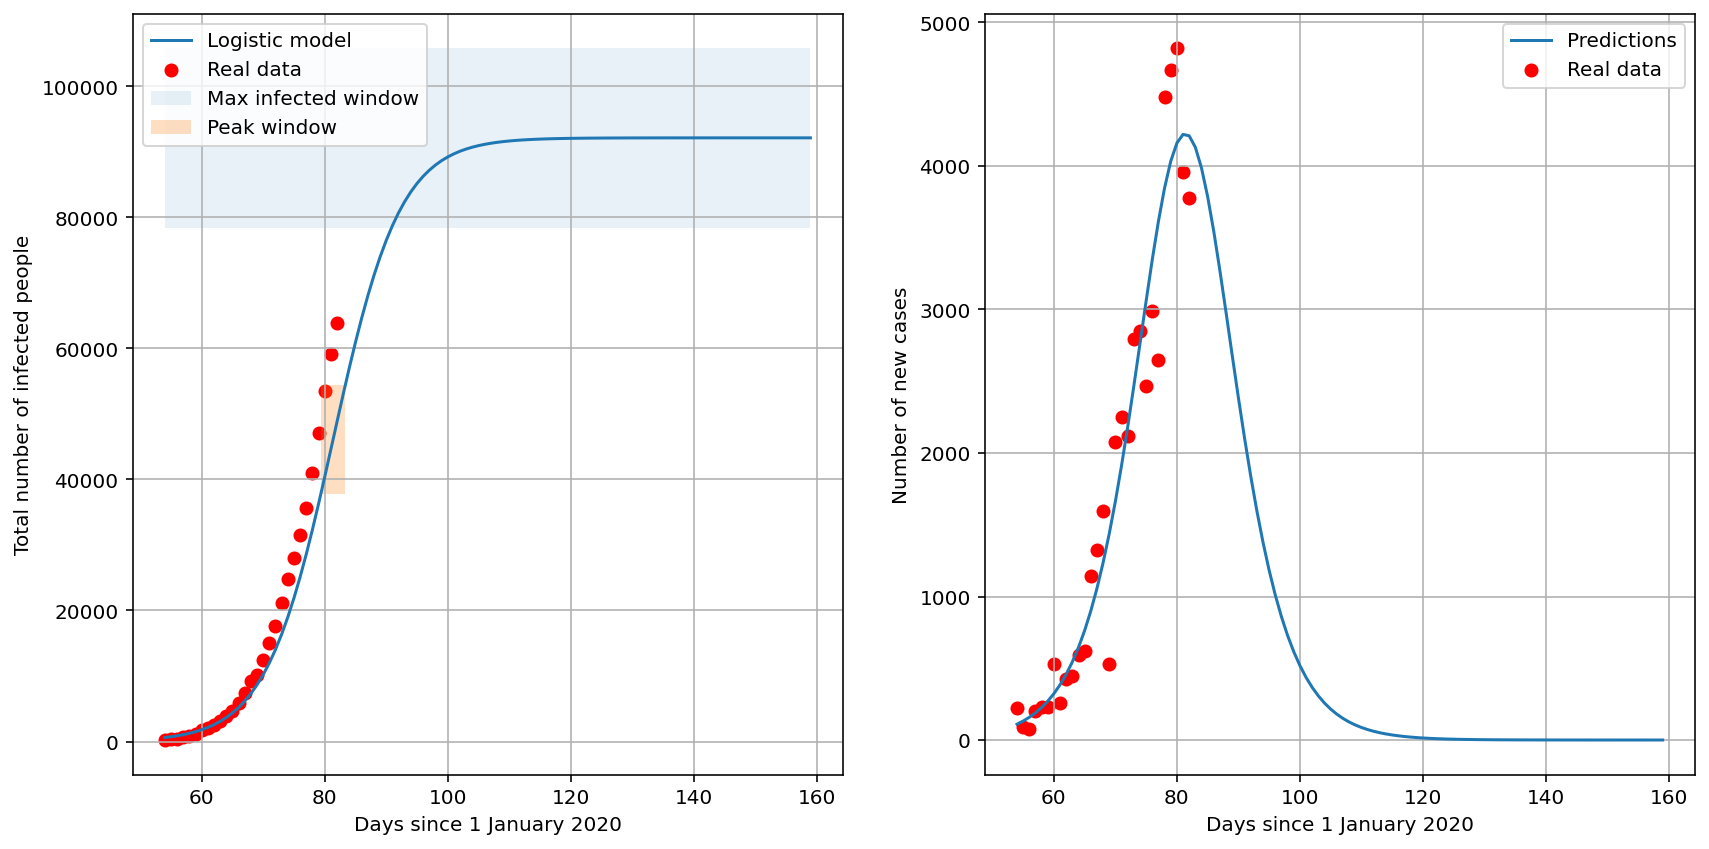

In [10]:
pred_x = np.arange(x.min(), sol+1)
pred_total_cases = logistic_model(pred_x, a, b, c)
plt.subplot(1, 2, 1)
plt.scatter(x, total_cases, label='Real data', color='red')
plt.plot(pred_x, pred_total_cases, label='Logistic model')
plt.fill_between(pred_x, c - err_c, c + err_c, alpha=0.1, label='Max infected window')
plt.fill_between([b - np.ceil(err_b), b + np.ceil(err_b)], 
                 logistic_model(b - np.ceil(err_b), a, b, c),
                 logistic_model(b + np.ceil(err_b), a, b, c),
                 alpha=0.25, label='Peak window')
plt.xlabel('Days since 1 January 2020')
plt.ylabel('Total number of infected people')
plt.legend()
plt.grid(True)

pred_new_cases = logistic_model_derivative(pred_x, a, b, c)
plt.subplot(1, 2, 2)
plt.scatter(x, new_cases, label='Real data', color='red')
plt.plot(pred_x, pred_new_cases, label='Predictions')
plt.xlabel('Days since 1 January 2020')
plt.ylabel('Number of new cases')
plt.legend()
plt.grid(True)

## Fit both curves simultaneously

In [11]:
DATA_SIZE = len(x)

def f(x, a, b, c):
    x1 = x[0:DATA_SIZE]
    x2 = x[DATA_SIZE:]
    y1 = logistic_model(x1, a, b, c)
    y2 = logistic_model_derivative(x2, a, b, c)
    return np.hstack([y1, y2])

fit = curve_fit(f, np.hstack([x, x]), np.hstack([total_cases, new_cases]), p0=[4, 100, 50000])
a, b, c = fit[0]
_, err_b, err_c = (np.sqrt(fit[1][i][i]) for i in [0, 1, 2])
sol = int(fsolve(lambda x : logistic_model(x, a, b, c) - int(c), b)[0])
print(f'Expected number of infected people = {c:.2f} ± {int(np.ceil(err_c))}')
print(f'Expected infection peak = {days_to_datetime(b)} ± {int(np.ceil(err_b))} days')
print(f'Expected infection end = {days_to_datetime(sol)}')

Expected number of infected people = 109652.54 ± 5444
Expected infection peak = 2020-03-21 ± 1 days
Expected infection end = 2020-05-22


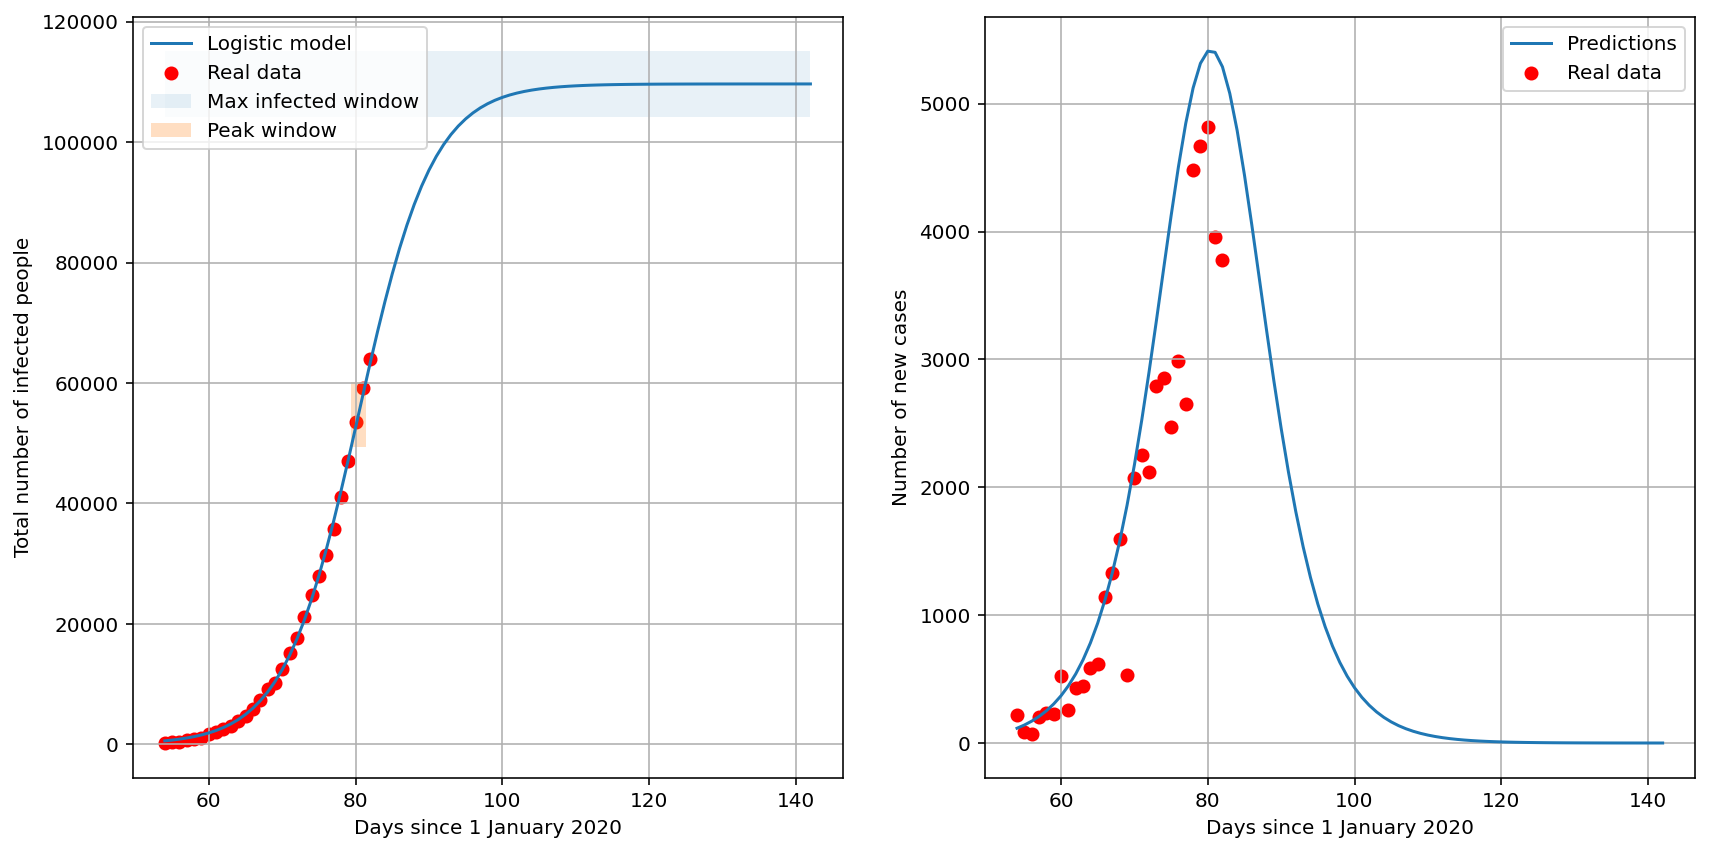

In [12]:
pred_x = np.arange(x.min(), sol+1)
pred_total_cases = logistic_model(pred_x, a, b, c)
plt.subplot(1, 2, 1)
plt.scatter(x, total_cases, label='Real data', color='red')
plt.plot(pred_x, pred_total_cases, label='Logistic model')
plt.fill_between(pred_x, c - err_c, c + err_c, alpha=0.1, label='Max infected window')
plt.fill_between([b - np.ceil(err_b), b + np.ceil(err_b)], 
                 logistic_model(b - np.ceil(err_b), a, b, c),
                 logistic_model(b + np.ceil(err_b), a, b, c),
                 alpha=0.25, label='Peak window')
plt.xlabel('Days since 1 January 2020')
plt.ylabel('Total number of infected people')
plt.legend()
plt.grid(True)

pred_new_cases = logistic_model_derivative(pred_x, a, b, c)
plt.subplot(1, 2, 2)
plt.scatter(x, new_cases, label='Real data', color='red')
plt.plot(pred_x, pred_new_cases, label='Predictions')
plt.xlabel('Days since 1 January 2020')
plt.ylabel('Number of new cases')
plt.legend()
plt.grid(True)